In [18]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd
import utils.functions as functions
from utils.functions import *
import importlib
import json
from utils.graph_repair import repair_network
import matplotlib.patches as patches
import itertools

%load_ext autoreload
%autoreload 2

cmap = get_colormap()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
input_file = 'dataset/old'


worm_dicts = read_input_mat_file(input_file, remove_trend=True, smooth_spikes=True, mean_zero=True, meanmax_thresh=None)
# worm_dicts[0]['annot'][480:595] = 1
# worm_dicts[0]['annot'][1600:] = 1
# worm_dicts[1]['annot'][875:] = 1
# worm_dicts[3]['annot'][:500] = 1

averaged_results = calculate_metrics(worm_dicts, use_annotations = True, return_average = True)

KeyboardInterrupt: 

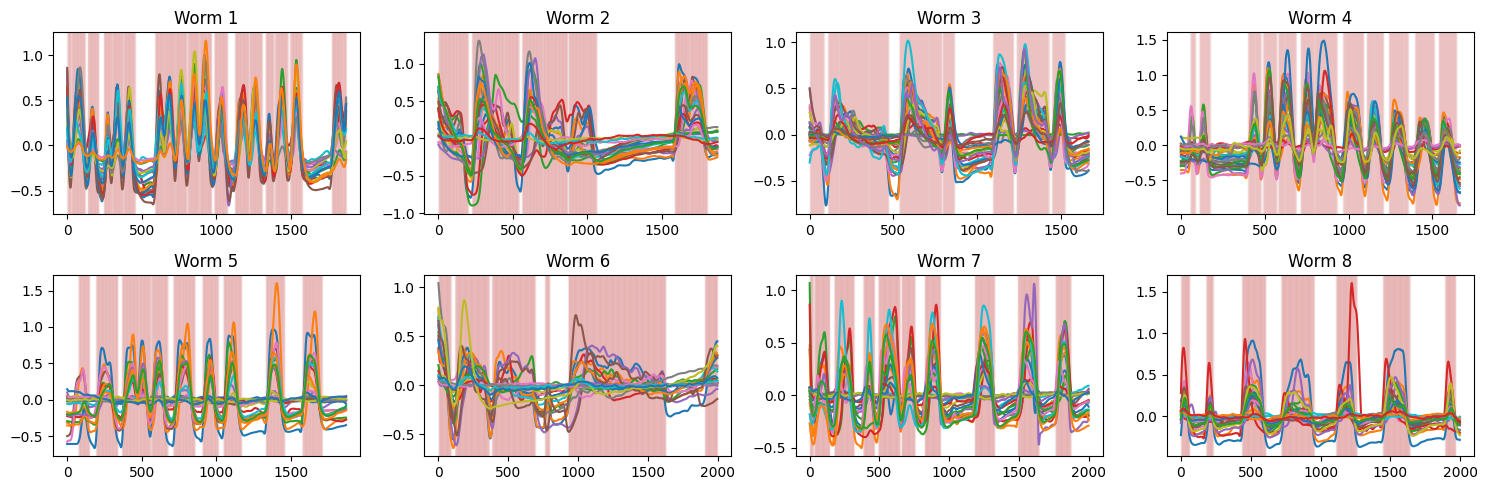

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(15, 5))
ax = ax.flatten()

for i, worm_dict in enumerate(worm_dicts):
    for key, value in worm_dict.items():
        if key == 'annot':
            for idx in range(len(value)):
                if value[idx] > 1:
                    ax[i].axvspan(idx, idx, color='tab:red', alpha=0.03)
        else:
            ax[i].plot(value)
    ax[i].set_title(f'Worm {i+1}')
    
plt.tight_layout()

In [ ]:
pairs = list(set(averaged_results.keys()))

## all neurons including AVAR, AVAL, etc
# all_neurons = list(set([item for sublist in pairs for item in sublist]))
# all_neurons.sort()

## to replicate the results in the paper
# all_neurons = ['VA05', 'VA06', 'VA07', 'DA07', 'DA08', 'VA04', 'DA09', 'DA02', 'VA02', 'DA03', 'VA01', 'DA01', 'DA06', 'DA04', 'VA08', 'DA05', 'VA11', 'VA09', 'VA10', 'VA03', 'VA12']
all_neurons = ['DA02', 'VA02', 'VA03', 'DA03', 'DA01', 'DA08', 'DA09', 'VA12', 'VA07', 'VA05', 'VA04', 'VA06', 'DA07', 'VA01', 'VA09', 'VA10', 'VA11', 'DA05', 'DA04', 'VA08', 'DA06']
# all_neurons = ['VA04', 'VA05', 'VA06', 'VA02', 'DA08', 'VA07', 'DA02', 'DA09', 'VA03', 'VA11', 'VA12', 'VA08', 'VA09', 'VA10', 'DA03', 'DA04', 'DA07', 'DA01', 'DA05', 'VA01', 'DA06']

mapping_neuron_to_idx = {all_neurons[idx]:idx for idx in range(len(all_neurons))}
mapping_idx_to_neuron = {idx:all_neurons[idx] for idx in range(len(all_neurons))}

In [ ]:
matrices = {}
modified_matrices = {}

for metric in averaged_results[pairs[0]]:
    matrix = np.ones((len(mapping_neuron_to_idx), len(mapping_neuron_to_idx)))
    for pair in pairs:
        if pair[0] in mapping_neuron_to_idx and pair[1] in mapping_neuron_to_idx:
            matrix[mapping_neuron_to_idx[pair[0]], mapping_neuron_to_idx[pair[1]]] = averaged_results[pair][metric]
            matrix[mapping_neuron_to_idx[pair[1]], mapping_neuron_to_idx[pair[0]]] = averaged_results[pair][metric]
    
    threshold = calculate_percolation(matrix)
    modified_matrix = np.where(matrix >= threshold, matrix, 0)
    
    matrices[metric] = matrix
    modified_matrices[metric] = modified_matrix

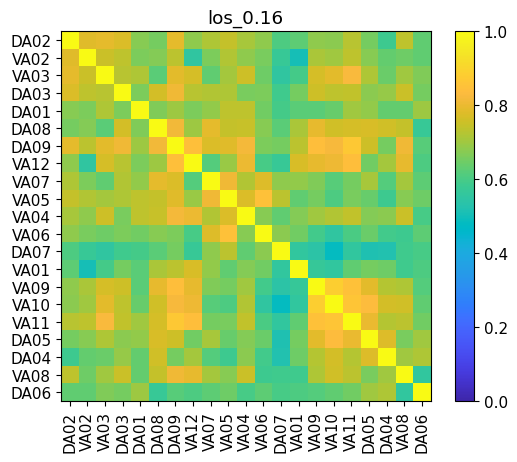

In [ ]:
plt.rcParams.update({'font.size': 11})

metric = 'los_0.16'
# metric = 'pearson'
# plt.imshow(np.where(matrices[metric]>0.64, matrices[metric], 0), cmap=cmap, vmin=0, vmax=1)
plt.imshow(matrices[metric], cmap=cmap, vmin=0, vmax=1)
# plt.imshow(matrices[metric], cmap=cmap, vmin=0, vmax=1)
plt.xticks(range(len(all_neurons)), all_neurons, rotation=90)
plt.yticks(range(len(all_neurons)), all_neurons)
plt.title(metric)
plt.colorbar();

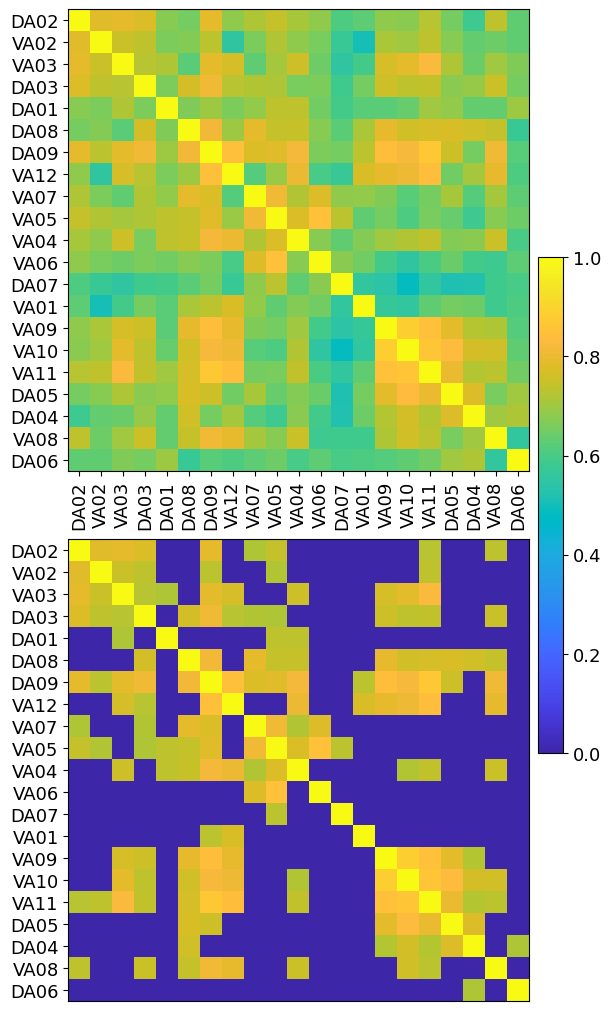

In [ ]:
plt.rcParams.update({'font.size': 13})

# Create figure and axes
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 10), constrained_layout=True)

# Plot heatmaps using imshow
im1 = axes[0].imshow(matrices[metric], cmap=cmap, aspect='auto', vmin=0, vmax=1)
im2 = axes[1].imshow(modified_matrices[metric], cmap=cmap, aspect='auto', vmin=0, vmax=1)
axes[0].set_xticks(range(len(all_neurons)), all_neurons, rotation=90)
axes[0].set_yticks(range(len(all_neurons)), all_neurons)
axes[1].set_xticks(range(len(all_neurons)), all_neurons, rotation=90)
axes[1].set_yticks(range(len(all_neurons)), all_neurons)
# Only show x-ticks on the top plot
axes[0].tick_params(bottom=True, labelbottom=True)  # Hide x-axis labels and ticks
axes[1].tick_params(top=False, bottom=False, labelbottom=False)  # Ensure no top ticks in the bottom plot

# Share the colorbar for both heatmaps
cbar = fig.colorbar(im1, ax=axes, orientation='vertical', shrink=0.5, pad=0.02)

# Show the plot
fig.savefig('plots/AB.svg')

In [ ]:
datatable = [['louvain', 'covariance', 'cov'], ['louvain', 'los_0.060000000000000005', 'los_06'],
             ['clique', 'covariance', 'cov'], ['clique', 'los_0.16', 'los_16'], ['clique', 'los_0.17', 'los_17']]

for method, metric, name in tqdm(datatable):
    all_cliques = []

    if method == 'louvain':
        louvain_results = louvain_clustering_best_modularity(modified_matrices[metric], all_neurons, 1000)
        clusters = louvain_results
    if method == 'clique':
        valid_cliques = check_cliques_struc_v2(modified_matrices[metric], all_neurons, 2, 9)
        refined_cliques = refine_cliques(valid_cliques)
        clusters = refined_cliques

    with open(f'colorings/{method[:4]}_{name}_colors_collapsed.txt', 'w') as f:
        for idx, clique in enumerate(clusters):
            for node in clique:
                print(f'{node}\t{idx}', file=f)
                
        print(f'AVE\t{idx+1}', file=f)
        
        print(f'AVD\t{idx+2}', file=f)
        
        print(f'AVA\t{idx+3}', file=f)
        
    with open(f'colorings/{method[:4]}_{name}_colors_uncollapsed.txt', 'w') as f:
        for idx, clique in enumerate(clusters):
            for node in clique:
                print(f'{node}\t{idx}', file=f)
            
        print(f'AVEL\t{idx+1}', file=f)
        print(f'AVER\t{idx+1}', file=f)
        
        print(f'AVDL\t{idx+2}', file=f)
        print(f'AVDR\t{idx+2}', file=f)
        
        print(f'AVAL\t{idx+3}', file=f)
        print(f'AVAR\t{idx+3}', file=f)

100%|██████████| 5/5 [04:27<00:00, 53.48s/it]


In [ ]:
collapsed = 'collapsed'
df_weights = pd.read_csv(f'connectomes/{collapsed}_varshney_weights.txt', sep='\t', header=None)
n_shuffle = 1000

res = {}

for run in tqdm(datatable):
    df = pd.read_csv(f"colorings/{run[0][:4]}_{run[2]}_colors_{collapsed}.txt", sep='\t', header=None)
    n_colors = str(df[~df[0].str.startswith('A')][1].max()+1)
    res[run[0]+ '-' + run[2] + '-' + n_colors] = {}
    for a in [1,2]:
        for b in [1,2]:
            
            shuffled_results = []
            for n in range(n_shuffle):
                shuffled_values = np.random.permutation(df.loc[~df[0].str.startswith('A'), 1].values)
                df_copy = df.copy()
                df_copy.loc[~df_copy[0].str.startswith('A'), 1] = shuffled_values
                df_copy.to_csv(f"colorings/temp_shuffle.txt", sep='\t', header=None, index=None)
                EdgesRemoved, EdgesAdded, G_result = repair_network(f"colorings/temp_shuffle.txt", f"connectomes/{collapsed}_varshney.graph.txt", f"outputs/{collapsed}_{run[0][:4]}_{run[2]}_colors_o_", a, b, prohibit_file_path=f"connectomes/{collapsed}_prohibited_edges.txt")
                shuffled_results.append(1.0*(sum([df_weights[(df_weights[0] == edge[0]) & (df_weights[1] == edge[1])][2].values[0] for edge in EdgesRemoved]) + len(EdgesAdded)) / df_weights[2].sum())
            
            EdgesRemoved, EdgesAdded, G_result = repair_network(f"colorings/{run[0][:4]}_{run[2]}_colors_{collapsed}.txt", f"connectomes/{collapsed}_varshney.graph.txt", f"outputs/{collapsed}_{run[0][:4]}_{run[2]}_colors_o_", a, b, prohibit_file_path=f"connectomes/{collapsed}_prohibited_edges.txt")
            # res[run[0]+ '-' + run[2]][(a,b)] = [(len(EdgesRemoved)+len(EdgesAdded))/56.0]
            res[run[0]+ '-' + run[2] + '-' + n_colors][(a,b)] = ((sum([df_weights[(df_weights[0] == edge[0]) & (df_weights[1] == edge[1])][2].values[0] for edge in EdgesRemoved]) + len(EdgesAdded)) / df_weights[2].sum(), 
                                                                 (np.array(shuffled_results) < (sum([df_weights[(df_weights[0] == edge[0]) & (df_weights[1] == edge[1])][2].values[0] for edge in EdgesRemoved]) + len(EdgesAdded)) / df_weights[2].sum()).sum() / n_shuffle)
            # res[run[0]+ '-' + run[2]][(a,b)] = (sum([df_weights[(df_weights[0] == edge[0]) & (df_weights[1] == edge[1])][2].values[0] for edge in EdgesRemoved]) + len(EdgesAdded)) / df_weights.shape[0]
            

In [ ]:
import matplotlib.cm as cm

colormap = cm.get_cmap('tab10', 8)

color_dict = {
    1: '223,137,255',
    2: '121,114,255',
    3: '115,192,0',
    4: '255,136,5',
    5: '0,196,255',
    6: '255,85,132',
    7: '0,189,148',
    8: '211,179,176'
}

/tmp/ipykernel_139844/1511950308.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab10', 8)


## Here

In [ ]:
df = pd.read_csv('connectomes/collapsed_varshney_weights.txt', sep='\t', header=None)
df.rename(columns={0: 'source', 1: 'target', 2: 'weight'}, inplace=True)

G_orig = nx.from_pandas_edgelist(df, create_using=nx.DiGraph, edge_attr='weight')
G_orig.add_node('VA07')

colors = pd.read_csv('colorings/cons_5_colors_collapsed.txt', sep='\t', header=None)

for row in colors.iterrows():
    G_orig.nodes[row[1][0]]['rgb'] = color_dict[row[1][1]]
    G_orig.nodes[row[1][0]]['color'] = row[1][1]

In [ ]:
EdgesRemoved, EdgesAdded, G_result = repair_network(f"colorings/cons_5_colors_collapsed.txt", "connectomes/collapsed_varshney.graph.txt", f"outputs/collapsed_colors_o_", a, b, prohibit_file_path="connectomes/collapsed_prohibited_edges.txt")

for row in colors.iterrows():
    G_result.nodes[row[1][0]]['rgb'] = color_dict[row[1][1]]
    G_result.nodes[row[1][0]]['color'] = row[1][1]
    
df_weights = pd.read_csv(f'connectomes/collapsed_varshney_weights.txt', sep='\t', header=None)
df_weights[2] *= 2
modification_epsilon(EdgesRemoved, EdgesAdded, df_weights, how='edge_weight_new')

0.23835616438356164

In [ ]:
from scipy.stats import norm

def one_sided_p_value(mean, std, x):
    z_score = (x - mean) / std
    p_value = norm.cdf(z_score)  # One-sided (upper tail) p-value
    return p_value

In [28]:
df_weights = pd.read_csv(f'connectomes/collapsed_varshney_weights.txt', sep='\t', header=None)

n = 5
rep = 1e9
prohib = "connectomes/collapsed_prohibited_edges.txt"
prohib = None
aa = 0
bb = 0

for n in [11,12]:
    for k in range(10):
        for a in [1,2]:
            for b in [1,2]:
                EdgesRemoved, EdgesAdded, G_result = repair_network(f"colorings/cons_{n}_colors_collapsed.txt", "connectomes/collapsed_varshney.graph.txt", f"outputs/collapsed_colors_o_", a, b, prohibit_file_path=prohib)
                r = modification_epsilon(EdgesRemoved, EdgesAdded, df_weights, how='edge_weight_new')
                if r < rep:
                    rep = r
                    aa = a
                    bb = b
    
    print(n, aa, bb, rep)

11 2 2 0.057534246575342465
12 2 1 0.0547945205479452


In [22]:
# reps = [0.10136986301369863,0.07945205479452055,0.07945205479452055,0.07123287671232877,0.07123287671232877,0.06301369863013699,0.06301369863013699,0.06027397260273973]
# reps = [0.16712328767123288, 0.136986301369863, 0.13424657534246576, 0.13424657534246576, 0.1232876712328767, 0.10684931506849316, 0.10410958904109589,0.10136986301369863]
reps = [0.10684931506849316, 0.10410958904109589, 0.09863013698630137, 0.0684931506849315]
ms = [(0.1726780821917808, 0.05357312776140421), (0.16199662802950476, 0.04823042330022775), (0.1531890410958904, 0.04784359257096977), (0.14416864535768648, 0.049519052321231584)]

for i in range(8):
    print(one_sided_p_value(ms[i][0], ms[i][1], reps[i]))

0.10958002406766254
0.11502727559264875
0.12706824092715097
0.06323024416302489


IndexError: list index out of range

In [ ]:
nx.write_gexf(G_orig, 'unc_orig.gexf')
# nx.write_gexf(G_result, 'c_rep.gexf')

In [ ]:
res = {}

collapsed = 'collapsed'
n_cluster = 5
df_weights = pd.read_csv(f'connectomes/{collapsed}_varshney_weights.txt', sep='\t', header=None)
df = pd.read_csv(f"colorings/cons_{n_cluster}_colors_{collapsed}.txt", sep='\t', header=None)
n_colors = str(df[~df[0].str.startswith('A')][1].max()+1)
res['cons-' + str(n_cluster) + f'-{collapsed}'] = {}

for a in [1]:
    for b in [1]:
        
        EdgesRemoved, EdgesAdded, G_result = repair_network(f"colorings/cons_{str(n_cluster)}_colors_{collapsed}.txt", f"connectomes/{collapsed}_varshney.graph.txt", f"outputs/{collapsed}_consensous_{str(n_cluster)}_colors_o_", a, b, prohibit_file_path=f"connectomes/{collapsed}_prohibited_edges.txt", verbose=False)
        # res[run[0]+ '-' + run[2]][(a,b)] = [(len(EdgesRemoved)+len(EdgesAdded))/56.0]
        repair_percentage = modification_epsilon(EdgesRemoved, EdgesAdded, df_weights, how='edge_weight')
        res['cons-' + str(n_cluster) + f'-{collapsed}'][(a,b)] = repair_percentage
        # res[run[0]+ '-' + run[2]][(a,b)] = (sum([df_weights[(df_weights[0] == edge[0]) & (df_weights[1] == edge[1])][2].values[0] for edge in EdgesRemoved]) + len(EdgesAdded)) / df_weights.shape[0]
        print(a,b,repair_percentage)

1 1 0.2


In [ ]:
# paper figure positions
# pos = {
#     'AVD': (0,0),
#     'AVE': (1,1),
#     'AVA': (-1,-1),
    
#     'VA04': (3,2),
#     'DA09': (3,1.5),
#     'DA08': (3,1),
#     'DA07': (3,0.5),
#     'VA07': (3,0),
#     'VA05': (3,-0.5),
#     'VA06': (3,-1),
    
#     'VA02': (-1,-2),
#     'DA02': (-0.5,-2),
#     'DA03': (0,-2),
#     'VA01': (0.5,-2),
    
#     'DA01': (1,4),
#     'DA06': (0,4),
#     'VA03': (-1,4),
#     'VA12': (-2,4),
    
#     'VA11': (-2,3),
#     'VA10': (-2,2.5),
#     'DA05': (-2,2),
#     'VA09': (-2,1.5),
#     'VA08': (-2,1),
#     'DA04': (-2,0.5),
# }

# worm body positions
pos = {
    'VA01': (0,0),
    'VA02': (1,0),
    'VA03': (2,0),
    'VA04': (3,0),
    'VA05': (4,0),
    'VA06': (5,0),
    'VA07': (6,0),
    'VA08': (7,0),
    'VA09': (8,0),
    'VA10': (9,0),
    'VA11': (10,0),
    'VA12': (11,0),
    
    'DA01': (0, 1),
    'DA02': (1, 1),
    'DA03': (2, 1),
    'DA04': (3, 1),
    'DA05': (4, 1),
    'DA06': (5, 1),
    'DA07': (6, 1),
    'DA08': (7, 1),
    'DA09': (8, 1),
    
    'AVA': (1, 0.5),
    'AVE': (2, 0.5),
    'AVD': (3, 0.5),
}

if 'AVAL' in G_orig.nodes():
    pos['AVAL'] = (1, 0.7)
    pos['AVAR'] = (1, 0.3)
    
    pos['AVEL'] = (2, 0.7)
    pos['AVER'] = (2, 0.3)
    
    pos['AVDL'] = (3, 0.7)
    pos['AVDR'] = (3, 0.3)

In [ ]:
# # paper's colorings
# G_orig.nodes['VA12']['color'] = 0
# G_orig.nodes['VA03']['color'] = 0

# G_orig.nodes['DA06']['color'] = 1
# G_orig.nodes['DA01']['color'] = 1

# G_orig.nodes['DA08']['color'] = 2
# G_orig.nodes['DA09']['color'] = 2
# G_orig.nodes['VA04']['color'] = 2

# G_orig.nodes['VA02']['color'] = 3
# G_orig.nodes['DA02']['color'] = 3
# G_orig.nodes['DA03']['color'] = 3

# G_orig.nodes['VA11']['color'] = 4
# G_orig.nodes['VA10']['color'] = 4
# G_orig.nodes['DA05']['color'] = 4
# G_orig.nodes['VA09']['color'] = 4
# G_orig.nodes['VA08']['color'] = 4
# G_orig.nodes['DA04']['color'] = 4

# G_orig.nodes['AVD']['color'] = 5

# G_orig.nodes['AVE']['color'] = 6

# G_orig.nodes['AVA']['color'] = 7

# G_orig.nodes['DA07']['color'] = 8
# G_orig.nodes['VA07']['color'] = 8
# G_orig.nodes['VA05']['color'] = 8
# G_orig.nodes['VA06']['color'] = 8

# G_orig.nodes['VA01']['color'] = 9

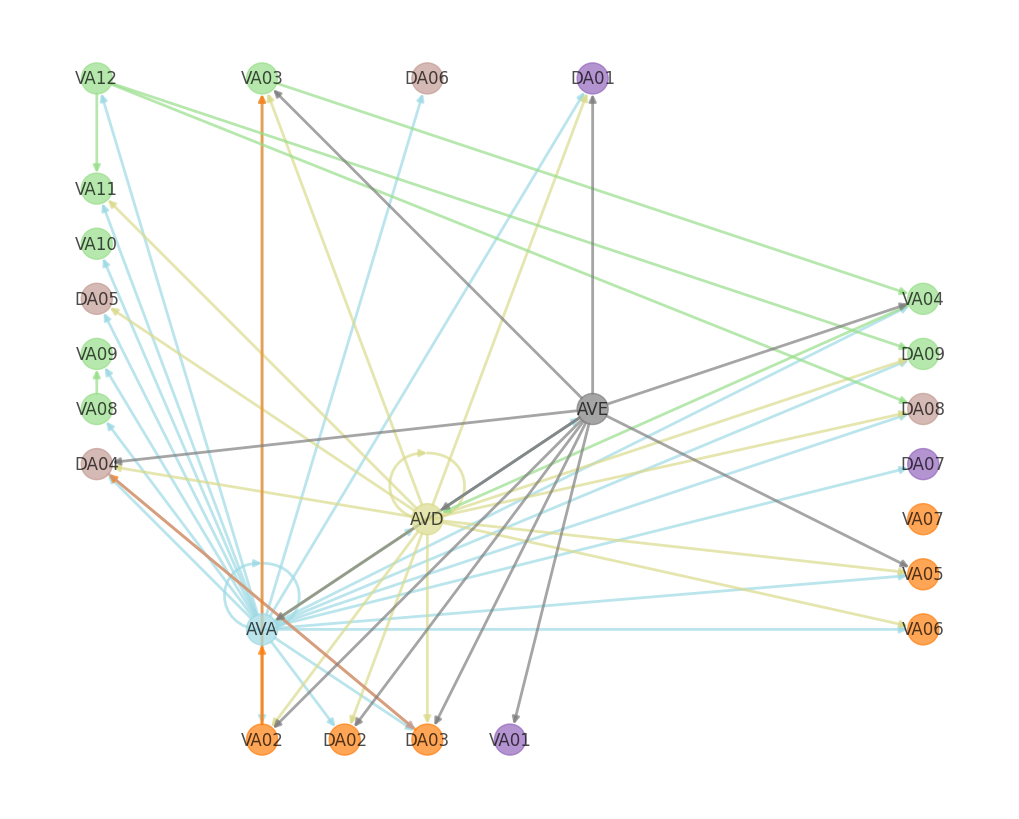

In [ ]:
plot_graph_with_weights_and_groups(G_orig, pos=pos, draw_edge_labels=False, uniform_edges=True)

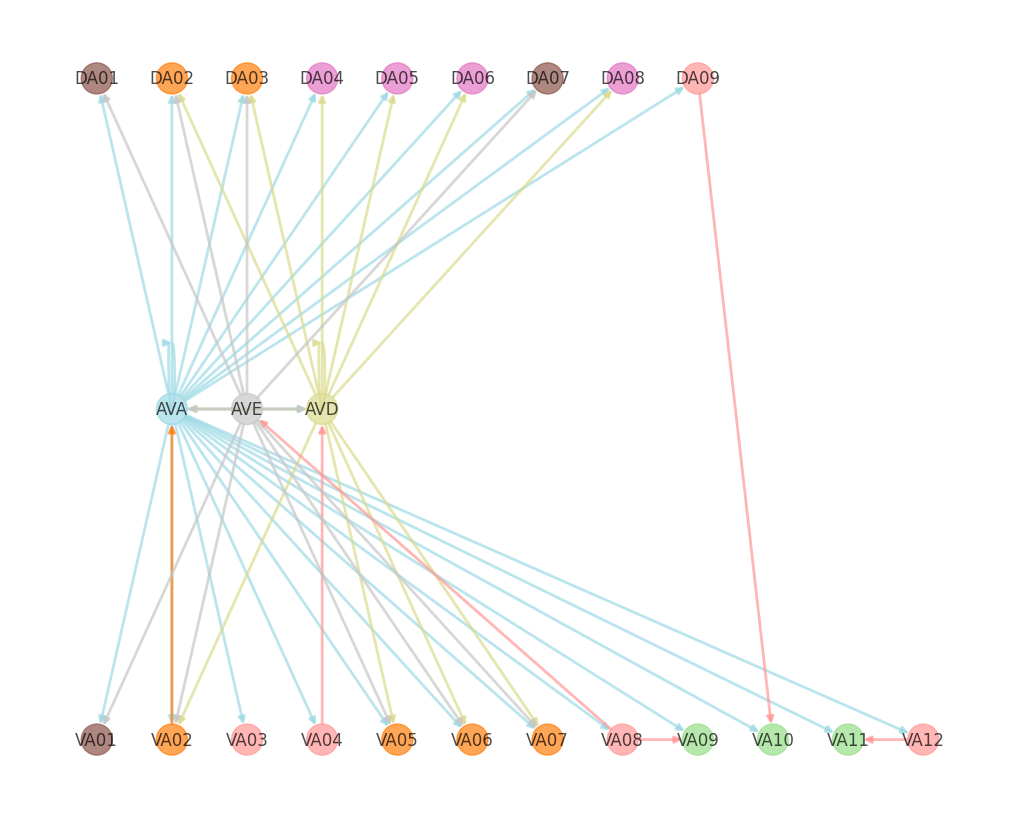

In [ ]:
plot_graph_with_weights_and_groups(G_result, pos=pos, draw_edge_labels=False, uniform_edges=True)

In [ ]:
try:
    with open('precomputed/all_cliques_detrend_demean_despike.json', 'r') as file:
        # Load the JSON data from the file
        all_cliques = json.load(file)
except:
    all_cliques = []

    for metric, matrix in tqdm(modified_matrices.items(), total=len(modified_matrices)):
        valid_cliques = check_cliques_struc_v2(matrix, all_neurons, 2, 9)
        refined_cliques = refine_cliques(valid_cliques)
        louvain_results = louvain_clustering_best_modularity(matrix, all_neurons, 100)
        
        all_cliques.append(refined_cliques)
        all_cliques.append(louvain_results)
        
    # Convert the list to a JSON string
    json_string = json.dumps(all_cliques)

    # Save the JSON string to a file
    with open("precomputed/all_cliques_detrend_demean_despike.json", "w") as f:
        f.write(json_string)

In [ ]:
def create_point_cluster_mapping(clustering_results, columns):
    points = set()
    metric_cluster_mapping = []

    # Collect unique points and map their clusters
    for metric in clustering_results:
        metric_map = {}
        for cluster_id, cluster_points in enumerate(metric):
            for point in cluster_points:
                metric_map[point] = cluster_id
                points.add(point)
        metric_cluster_mapping.append(metric_map)

    # Convert to DataFrame
    points = sorted(points)  # Ensure consistent ordering
    data = []
    for metric_map in metric_cluster_mapping:
        data.append([metric_map.get(point, -1) for point in points])  # -1 if point is not in metric

    return pd.DataFrame(data, index=columns, columns=points).T

In [ ]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, jaccard_score

metric_names = [[x[:10]+'_c', x[:10]+'_l'] for x in list(modified_matrices.keys())]
metric_names = sum(metric_names, [])

df = create_point_cluster_mapping(list(all_cliques.values()), metric_names)
res = np.zeros((len(df.columns), len(df.columns)))

for col1 in enumerate(df.columns):
    for col2 in enumerate(df.columns):
        # res[col1[0], col2[0]] = adjusted_rand_score(df[col1[1]], df[col2[1]])
        res[col1[0], col2[0]] = normalized_mutual_info_score(df[col1[1]], df[col2[1]])
        # res_clique[col1[0], col2[0]] = normalized_mutual_info_score(df_clusters_cliq[col1[1]], df_clusters_cliq[col2[1]]
        # res[col1[0], col2[0]] = jaccard_score(df[col1[1]], df[col2[1]], average='macro')

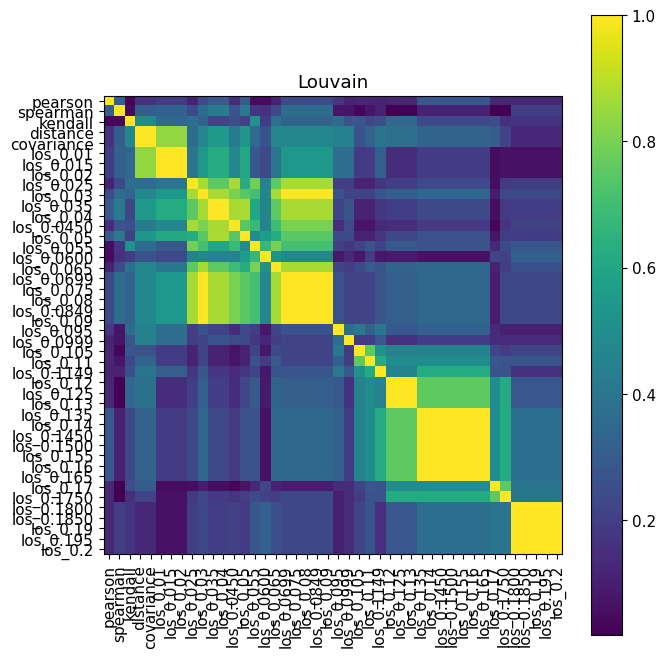

In [ ]:
plt.figure(figsize=(7, 7))
# plt.imshow(res[::2, ::2], cmap='viridis')
# plt.title('Clique')
plt.imshow(res[1::2, 1::2], cmap='viridis')
plt.title('Louvain')

plt.xticks(range(44), [x[:-2] for x in metric_names[1::2]], rotation=90)
plt.yticks(range(44), [x[:-2] for x in metric_names[1::2]])
plt.colorbar()

plt.tight_layout()

In [ ]:
def get_thresholds_for_clusters(linkage_matrix):
    """
    Given a SciPy linkage matrix, compute the threshold values that lead to different cluster counts.
    
    Parameters:
        linkage_matrix (ndarray): The linkage matrix from scipy's hierarchical clustering.

    Returns:
        dict: A mapping from number of clusters to the corresponding threshold.
    """
    num_points = linkage_matrix.shape[0] + 1  # Initial clusters = number of original points
    thresholds = {num_points: 0}  # Start with N clusters (threshold = 0)
    
    for i, row in enumerate(linkage_matrix):
        cluster_count = num_points - (i + 1)  # Number of clusters at this step
        threshold = row[2]  # The merge distance at this step
        thresholds[cluster_count] = threshold
    
    return thresholds

In [ ]:
thresh = get_thresholds_for_clusters(linkage_matrix)
thresh

{21: 0,
 20: 0.0514896145500656,
 19: 0.09128133038916808,
 18: 0.09795278524810502,
 17: 0.19729688675754192,
 16: 0.2557259927357538,
 15: 0.3010732810556014,
 14: 0.30955005199900926,
 13: 0.3970920684735346,
 12: 0.4676101583524677,
 11: 0.5424767507673398,
 10: 0.7353329560429743,
 9: 0.8088326940591094,
 8: 0.9215880751343134,
 7: 1.0470740639718352,
 6: 1.222311484296254,
 5: 1.4267450947730314,
 4: 2.304113792650434,
 3: 2.6970393838224975,
 2: 3.9419208513053636,
 1: 6.0774332221909395}

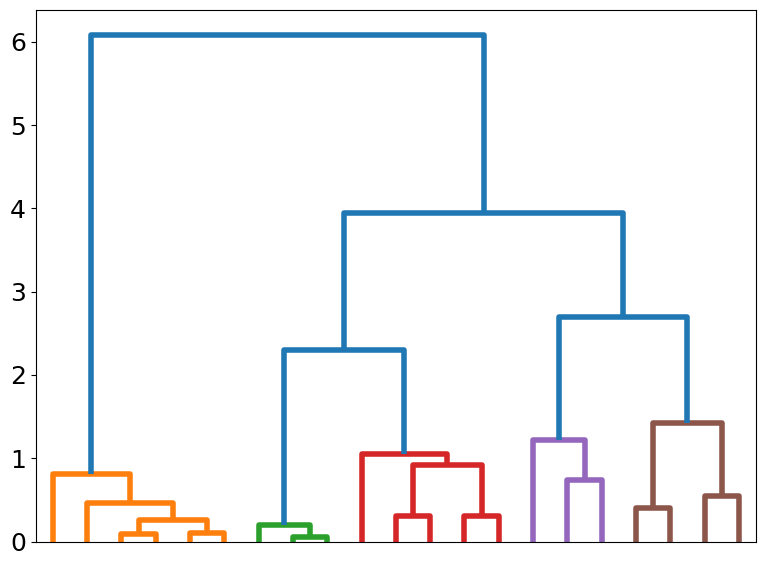

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
plt.rcParams.update({'font.size': 18})
temp =  ['VA05', 'VA06', 'VA07', 'DA07', 'DA08', 'VA04', 'DA09', 'DA02', 'VA02', 'DA03', 'VA01', 'DA01', 'DA06', 'DA04', 'VA08', 'DA05', 'VA11', 'VA09', 'VA10', 'VA03', 'VA12']
mapping = {x:mapping_neuron_to_idx[x] for x in temp}
mapping = mapping_neuron_to_idx
cooccurrence_matrix = get_cooccurrence_matrix(list(all_cliques.values()), mapping)

# Step 4: Perform Hierarchical Clustering using Ward's Method
linkage_matrix = linkage(cooccurrence_matrix, method='ward')

# Step 5: Plot the Dendrogram
plt.figure(figsize=(8, 6))
with plt.rc_context({'lines.linewidth': 4}):
    dendo = dendrogram(linkage_matrix, labels=all_neurons, color_threshold=1.5)

cooccurrence_matrix = cooccurrence_matrix[np.ix_(dendo['leaves'], dendo['leaves'])]

new_node_order = [all_neurons[node] for node in dendo['leaves']]
# new_node_order = temp

# plt.title("Hierarchical Clustering Dendrogram")
# plt.xlabel("Nodes")
plt.xticks([])
plt.tight_layout()
# plt.ylabel("Distance")
plt.savefig('plots/dendrogram.svg')

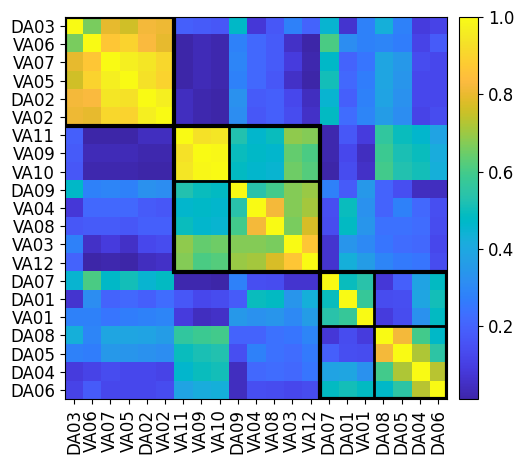

In [ ]:
plt.rcParams.update({'font.size': 12})

plt.imshow(cooccurrence_matrix, cmap=cmap)
plt.xticks(range(len(new_node_order)), new_node_order, rotation=90)
plt.yticks(range(len(new_node_order)), new_node_order)
plt.colorbar(pad=0.02)

squares = [
    [0, 5, 3],
    [6, 13, 3],
    [14, 20, 3],
    
    [0, 5, 2],
    [6, 8, 2],
    [9, 13, 2],
    [14, 16, 2],
    [17, 20, 2],
]

for start, end, thickness in squares:
    # Add a square (rectangle with equal height and width)
    ax = plt.gca()
    rect = patches.Rectangle(
        (start - 0.5, start - 0.5),  # Rectangle starts slightly offset to align with pixels
        end - start + 1,            # Width
        end - start + 1,            # Height
        linewidth=thickness,                    # Line thickness
        edgecolor='black',                # Line color
        facecolor='none'                # Transparent fill
    )
    ax.add_patch(rect)

plt.tight_layout()
plt.savefig('plots/cooccurrence.svg')

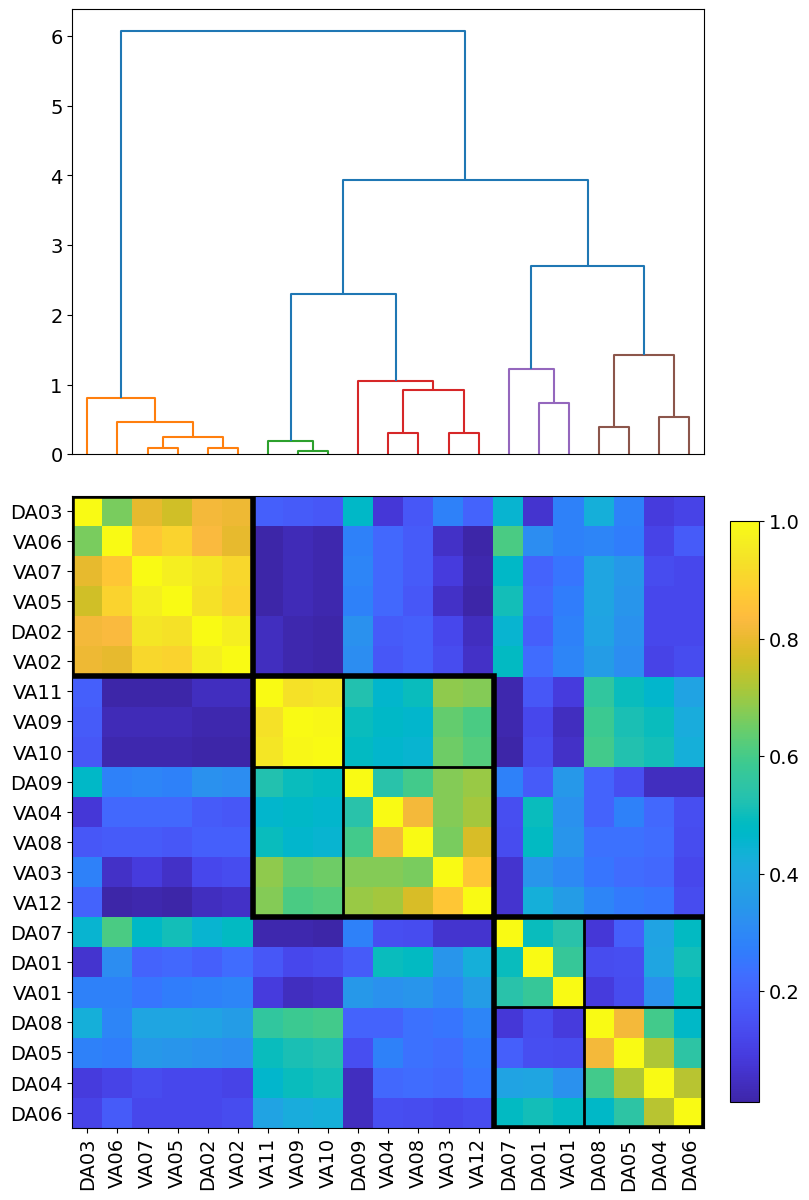

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
from scipy.cluster.hierarchy import linkage, dendrogram

plt.rcParams.update({'font.size': 14})
# Assuming cooccurrence_matrix and other necessary data are precomputed
cooccurrence_matrix = get_cooccurrence_matrix(list(all_cliques.values()), mapping_neuron_to_idx)

# Step 1: Perform Hierarchical Clustering using Ward's Method
linkage_matrix = linkage(cooccurrence_matrix, method='ward')

# Step 2: Create a figure with 2 rows and shared x-axis, larger heatmap
fig, axes = plt.subplots(
    2, 1, figsize=(8, 12), gridspec_kw={'height_ratios': [1, 1.5]}, sharex=False, constrained_layout=True
)

# Step 3: Plot the Dendrogram on the first subplot
dendro = dendrogram(linkage_matrix, labels=all_neurons, color_threshold=1.5, ax=axes[0])
# axes[0].set_ylabel("Distance")
axes[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Reorder the co-occurrence matrix based on the dendrogram order
cooccurrence_matrix = cooccurrence_matrix[np.ix_(dendro['leaves'], dendro['leaves'])]
new_node_order = [all_neurons[node] for node in dendro['leaves']]

# Step 4: Plot the reordered co-occurrence matrix on the second subplot
im = axes[1].imshow(cooccurrence_matrix, cmap=cmap)
axes[1].set_xticks(range(len(new_node_order)))
axes[1].set_xticklabels(new_node_order, rotation=90)
axes[1].set_yticks(range(len(new_node_order)))
axes[1].set_yticklabels(new_node_order)

# Add color bar to the right
cbar = plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

# Step 5: Add bounding boxes to highlight groups
squares = [
    [0, 5, 4],
    [6, 13, 4],
    [14, 20, 4],
    
    [0, 5, 2],
    [6, 8, 2],
    [9, 13, 2],
    [14, 16, 2],
    [17, 20, 2],
]

ax = axes[1]  # Use the second axis (heatmap)
for start, end, thickness in squares:
    rect = patches.Rectangle(
        (start - 0.5, start - 0.5),  # Rectangle starts slightly offset to align with pixels
        end - start + 1,             # Width
        end - start + 1,             # Height
        linewidth=thickness,         # Line thickness
        edgecolor='black',           # Line color
        facecolor='none'             # Transparent fill
    )
    ax.add_patch(rect)

# Final adjustments
fig.savefig('plots/FG.svg')

In [ ]:
def remove_duplicates(nested_list):
    seen = set()
    unique_list = []
    
    for sublist in nested_list:
        # Convert inner lists to sorted tuples
        sorted_sublist = tuple(tuple(sorted(inner)) for inner in sublist)
        
        if sorted_sublist not in seen:
            seen.add(sorted_sublist)
            unique_list.append(sublist)
    
    return unique_list

In [ ]:
len(remove_duplicates([v for k, v in all_cliques.items() if k[0]!='l' and k[-1]=='n']))

4

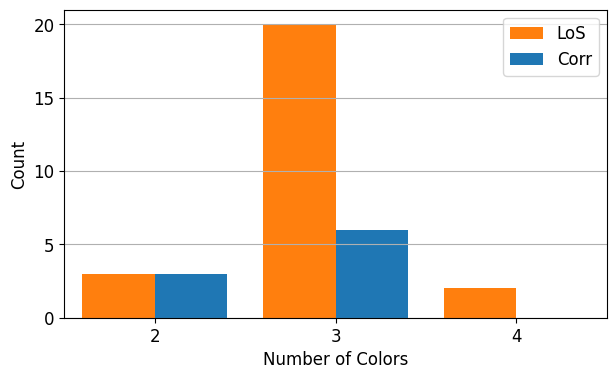

In [ ]:
from collections import Counter
plt.rcParams.update({'font.size': 12})

plt.figure(figsize=(7,4))

size_dist = [len(x) for x in remove_duplicates([v for k, v in all_cliques.items() if k[0]=='l'])]
count_dict = Counter(size_dist)

plt.bar(x=[x-0.2 for x in count_dict.keys()], height=count_dict.values(), width=0.4, label='LoS', color='tab:orange')

size_dist = [len(x) for x in remove_duplicates([v for k, v in all_cliques.items() if k[0]!='l'])]
count_dict = Counter(size_dist)

plt.bar(x=[x+0.2 for x in count_dict.keys()], height=count_dict.values(), width=0.4, label='Corr', color='tab:blue')

plt.grid(True, 'major', 'y')
plt.xlim([1.5,4.5])

plt.xticks([2,3,4])
plt.yticks([0,5,10,15,20])
plt.xlabel('Number of Colors')
plt.ylabel('Count')
plt.legend()

In [ ]:
for n_cluster in [3,4,5,6,7,8,9,10]:
    clusters = fcluster(linkage_matrix, n_cluster, criterion='maxclust')
    
    with open(f'colorings/cons_{n_cluster}_colors_collapsed.txt', 'w') as f:
        max_id = np.max(clusters)
        for idx, neuron in enumerate(all_neurons):
            print(f'{neuron}\t{clusters[idx]}', file=f)
            
        print(f'AVE\t{max_id+1}', file=f)
        
        print(f'AVD\t{max_id+2}', file=f)
        
        print(f'AVA\t{max_id+3}', file=f)

In [ ]:
collapsed = 'collapsed'
df_weights = pd.read_csv(f'connectomes/{collapsed}_varshney_weights.txt', sep='\t', header=None)

res = {}

for idx, i in enumerate([3,4,5,6,7,8,9,10]):
    res[i] = {}
    for a in [1,2]:
        for b in [1,2]:
            EdgesRemoved,EdgesAdded, G_result = repair_network(f"colorings/cons_{i}_colors_collapsed.txt", "connectomes/collapsed_varshney.graph.txt", f"outputs/collapsed_cons_{i}_colors_o_", a, b, prohibit_file_path="connectomes/collapsed_prohibited_edges.txt")
            res[i][(a,b)] = (sum([df_weights[(df_weights[0] == edge[0]) & (df_weights[1] == edge[1])][2].values[0] for edge in EdgesRemoved]) + len(EdgesAdded)) / df_weights[2].sum()

created all pairs
connectomes/collapsed_prohibited_edges.txt
Read prohibited edges: 59 prohibited edges
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2598042
Academic license 2598042 - for non-commercial use only - registered to ah___@gradcenter.cuny.edu
Setup time: 0.13201189041137695
Set parameter MIPGap to value 0.1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.2.0 24C101)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPGap  0.1

Academic license 2598042 - for non-commercial use only - registered to ah___@gradcenter.cuny.edu
Optimize a model with 4776 rows, 3649 columns and 33870 nonzeros
Model fingerprint: 0x46848163
Model has 212 simple general constraints
  212 ABS
Variable types: 129 continuous, 3096 integer (3096 binary)
Semi-Variable types: 0 continuous, 424 integer
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective ran

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# plt.rcParams.update({'font.size': 15})

# # Plotting
# fig, ax1 = plt.subplots(figsize=(8,5))

# # Plot the first numbers
# ax1.set_xlabel('Number of Clusters')
# ax1.set_ylabel('Modification')
# ax1.tick_params(axis='y')

# # Create a second y-axis
# ax2 = ax1.twinx()
# ax2.set_ylabel('P-Value')

# ax2.tick_params(axis='y')
# ax2.axhline(y=0.05, color='grey', linestyle='--')


# df = pd.read_csv('res_cons_collapsed.csv')
# df = pd.DataFrame(df.values.T)

# # Combine the first two rows into the headers
# new_columns = [
#     f"{df.iloc[0, col]}{df.iloc[1, col]}"
#     for col in range(df.shape[1])
# ]

# # Assign the new column headers
# df.columns = new_columns

# # Drop the first two rows and reset the index starting from 3
# df = df.iloc[2:].reset_index(drop=True)
# df.index += 3
# df = df.map(lambda x: eval(x) if isinstance(x, str) and x.startswith('(') and x.endswith(')') else x)

# # Find the tuple with the lowest second number in each row
# min_values = df.map(lambda x: x if isinstance(x, tuple) else None).apply(
#     lambda row: min(row, key=lambda x: x[1] if x else float('inf')), axis=1
# )

# # Extract the first and second numbers from the tuples
# first_numbers = min_values.map(lambda x: x[0])
# second_numbers = min_values.map(lambda x: x[1])

# ax2.plot(second_numbers.index, second_numbers, '--o', label='Collapsed P-Val', color='tab:blue')
# ax1.plot(first_numbers.index, first_numbers, '-o', label='Collapsed Repair', color='tab:blue')


# df = pd.read_csv('res_cons_uncollapsed.csv')
# df = pd.DataFrame(df.values.T)

# # Combine the first two rows into the headers
# new_columns = [
#     f"{df.iloc[0, col]}{df.iloc[1, col]}"
#     for col in range(df.shape[1])
# ]

# # Assign the new column headers
# df.columns = new_columns

# # Drop the first two rows and reset the index starting from 3
# df = df.iloc[2:].reset_index(drop=True)
# df.index += 3
# df = df.map(lambda x: eval(x) if isinstance(x, str) and x.startswith('(') and x.endswith(')') else x)

# # Find the tuple with the lowest second number in each row
# min_values = df.map(lambda x: x if isinstance(x, tuple) else None).apply(
#     lambda row: min(row, key=lambda x: x[1] if x else float('inf')), axis=1
# )

# # Extract the first and second numbers from the tuples
# first_numbers = min_values.map(lambda x: x[0])
# second_numbers = min_values.map(lambda x: x[1])

# ax2.plot(second_numbers.index, second_numbers, '--o', label='Uncollapsed P-Val', color='tab:red')
# ax1.plot(first_numbers.index, first_numbers, '-o', label='Uncollapsed Repair', color='tab:red')

# ax1.set_ylim([0.1, 0.25])
# ax2.set_ylim([0,0.16])

# fig.tight_layout()  # Adjust layout to prevent overlap
# plt.grid('on')
# fig.legend()
# plt.show()

## Plots

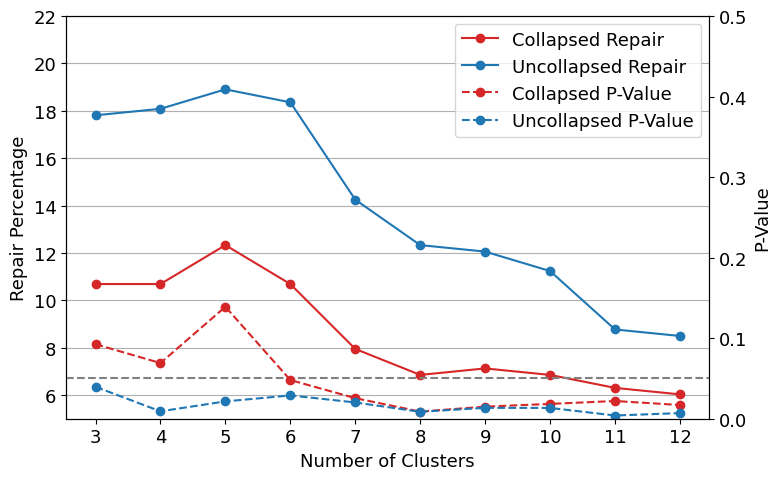

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

plt.rcParams.update({'font.size': 13})

# Plotting
fig, ax1 = plt.subplots(figsize=(8,5))

# Plot the first numbers
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Repair Percentage')
ax1.tick_params(axis='y')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('P-Value')

ax2.tick_params(axis='y')
ax2.axhline(y=0.05, color='grey', linestyle='--')


df = pd.read_csv('res_cons_prohibit_collapsed.csv')
df = pd.DataFrame(df.values.T)

# Combine the first two rows into the headers
new_columns = [
    f"{df.iloc[0, col]}{df.iloc[1, col]}"
    for col in range(df.shape[1])
]

# Assign the new column headers
df.columns = new_columns

# Drop the first two rows and reset the index starting from 3
df = df.iloc[2:].reset_index(drop=True)
df.index += 3
df = df.map(lambda x: eval(x) if isinstance(x, str) and x.startswith('(') and x.endswith(')') else x)

repairs = []
pvals = []
n_colors = []

for row in df.iterrows():
    n_colors.append(int(row[0]))
    best_repair = 1e100
    best_pval = 1.0
    
    for tup in row[1].values:
        if best_pval < 0.05 and tup[1] < 0.05 and tup[0] < best_repair: # already found a significant result, looking for better repair
            best_repair = tup[0]
            best_pval = tup[1]
        elif tup[1] < best_pval: # not found a significant result yet
            best_pval = tup[1]
            best_repair = tup[0]
    
    repairs.append(best_repair*100.0)
    pvals.append(best_pval)
    
ax2.plot(n_colors, pvals, '--o', label='Collapsed P-Value', color='tab:red')
ax1.plot(n_colors, repairs, '-o', label='Collapsed Repair', color='tab:red')


##############################

df = pd.read_csv('res_cons_prohibit_uncollapsed.csv')
df = df[[x for idx, x in enumerate(df.columns) if 'un' in x or idx < 2]]
df = pd.DataFrame(df.values.T)

# Combine the first two rows into the headers
new_columns = [
    f"{df.iloc[0, col]}{df.iloc[1, col]}"
    for col in range(df.shape[1])
]

# Assign the new column headers
df.columns = new_columns

# Drop the first two rows and reset the index starting from 3
df = df.iloc[2:].reset_index(drop=True)
df.index += 3
df = df.map(lambda x: eval(x) if isinstance(x, str) and x.startswith('(') and x.endswith(')') else x)

repairs = []
pvals = []
n_colors = []

for row in df.iterrows():
    n_colors.append(int(row[0]))
    best_repair = 1e100
    best_pval = 1.0
    
    for tup in row[1].values:
        if best_pval < 0.05 and tup[1] < 0.05 and tup[0] < best_repair: # already found a significant result, looking for better repair
            best_repair = tup[0]
            best_pval = tup[1]
        elif tup[1] < best_pval: # not found a significant result yet
            best_pval = tup[1]
            best_repair = tup[0]
    
    repairs.append(best_repair*100.0)
    pvals.append(best_pval)
    
    
ax2.plot(n_colors, pvals, '--o', label='Uncollapsed P-Value', color='tab:blue')
ax1.plot(n_colors, repairs, '-o', label='Uncollapsed Repair', color='tab:blue')

ax1.set_xticks([3,4,5,6,7,8,9,10,11,12])

ax1.set_ylim([5, 22])
ax2.set_ylim([0,0.5])

# rect = Rectangle((4.75, 8.15), 0.5, 6, 
#                  linewidth=2, edgecolor='black', linestyle="--", facecolor='none')
# ax1.add_patch(rect)


fig.tight_layout()  # Adjust layout to prevent overlap
fig.legend(loc='upper right', bbox_to_anchor=(0.9,0.95))
ax1.grid('on','major','y')
# fig.savefig('plots/percentages_and_pvalues.png')

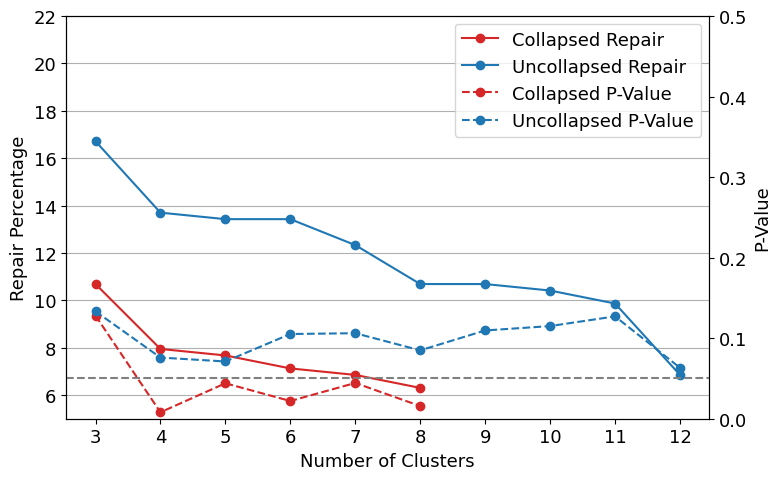

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

plt.rcParams.update({'font.size': 13})

# Plotting
fig, ax1 = plt.subplots(figsize=(8,5))

# Plot the first numbers
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Repair Percentage')
ax1.tick_params(axis='y')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('P-Value')

ax2.tick_params(axis='y')
ax2.axhline(y=0.05, color='grey', linestyle='--')


df = pd.read_csv('res_cons_none_collapsed.csv')
df = pd.DataFrame(df.values.T)

# Combine the first two rows into the headers
new_columns = [
    f"{df.iloc[0, col]}{df.iloc[1, col]}"
    for col in range(df.shape[1])
]

# Assign the new column headers
df.columns = new_columns

# Drop the first two rows and reset the index starting from 3
df = df.iloc[2:].reset_index(drop=True)
df.index += 3
df = df.map(lambda x: eval(x) if isinstance(x, str) and x.startswith('(') and x.endswith(')') else x)

repairs = []
pvals = []
n_colors = []

for row in df.iterrows():
    n_colors.append(int(row[0]))
    best_repair = 1e100
    best_pval = 1.0
    
    for tup in row[1].values:
        if best_pval < 0.05 and tup[1] < 0.05 and tup[0] < best_repair: # already found a significant result, looking for better repair
            best_repair = tup[0]
            best_pval = tup[1]
        elif tup[1] < best_pval: # not found a significant result yet
            best_pval = tup[1]
            best_repair = tup[0]
    
    repairs.append(best_repair*100.0)
    pvals.append(best_pval)
    
ax2.plot(n_colors, pvals, '--o', label='Collapsed P-Value', color='tab:red')
ax1.plot(n_colors, repairs, '-o', label='Collapsed Repair', color='tab:red')


##############################

df = pd.read_csv('res_cons_no_uncollapsed.csv')
df = df[[x for idx, x in enumerate(df.columns) if 'un' in x or idx < 2]]
df = pd.DataFrame(df.values.T)

# Combine the first two rows into the headers
new_columns = [
    f"{df.iloc[0, col]}{df.iloc[1, col]}"
    for col in range(df.shape[1])
]

# Assign the new column headers
df.columns = new_columns

# Drop the first two rows and reset the index starting from 3
df = df.iloc[2:].reset_index(drop=True)
df.index += 3
df = df.map(lambda x: eval(x) if isinstance(x, str) and x.startswith('(') and x.endswith(')') else x)

repairs = []
pvals = []
n_colors = []

for row in df.iterrows():
    n_colors.append(int(row[0]))
    best_repair = 1e100
    best_pval = 1.0
    
    for tup in row[1].values:
        if best_pval < 0.05 and tup[1] < 0.05 and tup[0] < best_repair: # already found a significant result, looking for better repair
            best_repair = tup[0]
            best_pval = tup[1]
        elif tup[1] < best_pval: # not found a significant result yet
            best_pval = tup[1]
            best_repair = tup[0]
    
    repairs.append(best_repair*100.0)
    pvals.append(best_pval)
    
    
ax2.plot(n_colors, pvals, '--o', label='Uncollapsed P-Value', color='tab:blue')
ax1.plot(n_colors, repairs, '-o', label='Uncollapsed Repair', color='tab:blue')

ax1.set_xticks([3,4,5,6,7,8,9,10,11,12])

ax1.set_ylim([5, 22])
ax2.set_ylim([0,0.5])

# rect = Rectangle((4.75, 8.15), 0.5, 6, 
#                  linewidth=2, edgecolor='black', linestyle="--", facecolor='none')
# ax1.add_patch(rect)


fig.tight_layout()  # Adjust layout to prevent overlap
fig.legend(loc='upper right', bbox_to_anchor=(0.9,0.95))
ax1.grid('on','major','y')
# fig.savefig('plots/percentages_and_pvalues.png')